# SLAMseq

## Installing slamdunk (only do once)

In [1]:
# install slamdunk
#! pip3 install git+https://github.com/jkobject/slamdunk.git --upgrade

In [ ]:
# clone and install genepy
# pip install -e genepy

In [2]:
# please also install cutadapt, fastqc, and trimgalore
#! conda install -c bioconda cutadapt
#! conda install -c bioconda fastqc
#! conda install -c bioconda trim-galore

In [1]:
from __future__ import print_function
import os.path
import pandas as pd
import sys
sys.path.insert(0, '../../')
import seaborn as sns
import numpy as np

from genepy.utils import helper as h
from genepy.utils import plot as genepyPlot
from genepy.rna import pyDESeq2
import genepy.rna as rna

In [3]:
from bokeh.plotting import *
from bokeh.models import HoverTool
from bokeh.io import output_notebook

import matplotlib.pyplot as plt

from sklearn.neighbors import KNeighborsClassifier
from sklearn.manifold import MDS, TSNE
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
#from umap import UMAP

output_notebook()
%load_ext autoreload
%matplotlib inline
%autoreload 2
%load_ext rpy2.ipython

Loading BokehJS ...

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [4]:
def createDir(directory):
    if not os.path.exists(directory):
        print("Creating output directory: " + directory)
        os.makedirs(directory)

# MV411 Mebendazole treatment

SLAMseq of Mebendazole treatment in MV411 cells 1h with drug + 1h 4sU with 10$\mu$M Mebendazole (with ERCC spike-in control)
<br>__Processed without alt loci__

In [5]:
project = "mebendazole_v1"

## download the data

In [6]:
project = "mebendazole_v1"
location = "../data/slamseq_"+project+"/" # new data location
loc = "220506_MP10011_fastq" # transfer AML folder

In [8]:
! mkdir ../$location
! mkdir ../results/slamseq_$project
! mkdir $location && mkdir $location/qc # make data dir in AMLproject
! mkdir ../$location/fastqs/ # make dir in /home/monika/data/project/fastqs

In [9]:
! gsutil ls gs://transfer-amlproject/$loc/

gs://transfer-amlproject/220506_MP10011_fastq/._multiqc_report.html
gs://transfer-amlproject/220506_MP10011_fastq/20220506_10_MebendazoleE_MP10011_S88_R1_001.fastq.gz
gs://transfer-amlproject/220506_MP10011_fastq/20220506_10_MebendazoleE_MP10011_S88_R2_001.fastq.gz
gs://transfer-amlproject/220506_MP10011_fastq/20220506_1_DMSOA_MP10011_S79_R1_001.fastq.gz
gs://transfer-amlproject/220506_MP10011_fastq/20220506_1_DMSOA_MP10011_S79_R2_001.fastq.gz
gs://transfer-amlproject/220506_MP10011_fastq/20220506_2_DMSOB_MP10011_S80_R1_001.fastq.gz
gs://transfer-amlproject/220506_MP10011_fastq/20220506_2_DMSOB_MP10011_S80_R2_001.fastq.gz
gs://transfer-amlproject/220506_MP10011_fastq/20220506_3_DMSOC_MP10011_S81_R1_001.fastq.gz
gs://transfer-amlproject/220506_MP10011_fastq/20220506_3_DMSOC_MP10011_S81_R2_001.fastq.gz
gs://transfer-amlproject/220506_MP10011_fastq/20220506_4_DMSOD_MP10011_S82_R1_001.fastq.gz
gs://transfer-amlproject/220506_MP10011_fastq/20220506_4_DMSOD_MP10011_S82_R2_001.fastq.gz
gs://t

In [10]:
location

'../data/slamseq_mebendazole_v1/'

In [11]:
# transfer qc files
! gsutil -m cp gs://transfer-amlproject/$loc/multiqc_report.html $location/qc/
! gsutil -m cp -r gs://transfer-amlproject/$loc/Reports/ $location/qc/
! gsutil -m cp -r gs://transfer-amlproject/$loc/multiqc_data/ $location/qc/

Copying gs://transfer-amlproject/220506_MP10011_fastq/multiqc_report.html...
/ [1/1 files][  1.3 MiB/  1.3 MiB] 100% Done                                    
Operation completed over 1 objects/1.3 MiB.                                      
Copying gs://transfer-amlproject/220506_MP10011_fastq/Reports/20220506_10_MebendazoleE_MP10011_S88_R1_001_fastqc.html...
Copying gs://transfer-amlproject/220506_MP10011_fastq/Reports/20220506_10_MebendazoleE_MP10011_S88_R1_001_fastqc.zip...
Copying gs://transfer-amlproject/220506_MP10011_fastq/Reports/20220506_10_MebendazoleE_MP10011_S88_R2_001_fastqc.html...
Copying gs://transfer-amlproject/220506_MP10011_fastq/Reports/20220506_10_MebendazoleE_MP10011_S88_R2_001_fastqc.zip...
Copying gs://transfer-amlproject/220506_MP10011_fastq/Reports/20220506_1_DMSOA_MP10011_S79_R1_001_fastqc.html...
Copying gs://transfer-amlproject/220506_MP10011_fastq/Reports/20220506_1_DMSOA_MP10011_S79_R1_001_fastqc.zip...
Copying gs://transfer-amlproject/220506_MP10011_fastq

In [12]:
! cp $location/qc/multiqc_report.html ../results/slamseq_$project

In [13]:
fastqs = ! gsutil ls gs://transfer-amlproject/$loc/*.gz

In [14]:
from natsort import os_sorted

In [17]:
fastqs = [fastq.split("/")[-1] for fastq in os_sorted(fastqs)]
# add sample names to AML sample tracker google sheet
for val1, val2 in h.grouped(fastqs, 2):
    print(val1.split("_R")[0])

20220506_1_DMSOA_MP10011_S79
20220506_2_DMSOB_MP10011_S80
20220506_3_DMSOC_MP10011_S81
20220506_4_DMSOD_MP10011_S82
20220506_5_DMSOE_MP10011_S83
20220506_6_MebendazoleA_MP10011_S84
20220506_7_MebendazoleB_MP10011_S85
20220506_8_MebendazoleC_MP10011_S86
20220506_9_MebendazoleD_MP10011_S87
20220506_10_MebendazoleE_MP10011_S88


In [18]:
# transfer fastqs
! gsutil -m cp gs://transfer-amlproject/$loc/*.fastq.gz ../$location/fastqs/

Copying gs://transfer-amlproject/220506_MP10011_fastq/20220506_10_MebendazoleE_MP10011_S88_R1_001.fastq.gz...
Copying gs://transfer-amlproject/220506_MP10011_fastq/20220506_10_MebendazoleE_MP10011_S88_R2_001.fastq.gz...
==> NOTE: You are downloading one or more large file(s), which would            
run significantly faster if you enabled sliced object downloads. This
feature is enabled by default but requires that compiled crcmod be
installed (see "gsutil help crcmod").

Copying gs://transfer-amlproject/220506_MP10011_fastq/20220506_1_DMSOA_MP10011_S79_R1_001.fastq.gz...
Copying gs://transfer-amlproject/220506_MP10011_fastq/20220506_1_DMSOA_MP10011_S79_R2_001.fastq.gz...
Copying gs://transfer-amlproject/220506_MP10011_fastq/20220506_2_DMSOB_MP10011_S80_R1_001.fastq.gz...
Copying gs://transfer-amlproject/220506_MP10011_fastq/20220506_2_DMSOB_MP10011_S80_R2_001.fastq.gz...
Copying gs://transfer-amlproject/220506_MP10011_fastq/20220506_3_DMSOC_MP10011_S81_R1_001.fastq.gz...
Copying gs://

## rename local fastqs

In [19]:
fastq_folder = "../"+location+"fastqs"
print(fastq_folder)
fastqs = ! ls $fastq_folder
fastqs

../../data/slamseq_mebendazole_v1/fastqs


['20220506_10_MebendazoleE_MP10011_S88_R1_001.fastq.gz',
 '20220506_10_MebendazoleE_MP10011_S88_R2_001.fastq.gz',
 '20220506_1_DMSOA_MP10011_S79_R1_001.fastq.gz',
 '20220506_1_DMSOA_MP10011_S79_R2_001.fastq.gz',
 '20220506_2_DMSOB_MP10011_S80_R1_001.fastq.gz',
 '20220506_2_DMSOB_MP10011_S80_R2_001.fastq.gz',
 '20220506_3_DMSOC_MP10011_S81_R1_001.fastq.gz',
 '20220506_3_DMSOC_MP10011_S81_R2_001.fastq.gz',
 '20220506_4_DMSOD_MP10011_S82_R1_001.fastq.gz',
 '20220506_4_DMSOD_MP10011_S82_R2_001.fastq.gz',
 '20220506_5_DMSOE_MP10011_S83_R1_001.fastq.gz',
 '20220506_5_DMSOE_MP10011_S83_R2_001.fastq.gz',
 '20220506_6_MebendazoleA_MP10011_S84_R1_001.fastq.gz',
 '20220506_6_MebendazoleA_MP10011_S84_R2_001.fastq.gz',
 '20220506_7_MebendazoleB_MP10011_S85_R1_001.fastq.gz',
 '20220506_7_MebendazoleB_MP10011_S85_R2_001.fastq.gz',
 '20220506_8_MebendazoleC_MP10011_S86_R1_001.fastq.gz',
 '20220506_8_MebendazoleC_MP10011_S86_R2_001.fastq.gz',
 '20220506_9_MebendazoleD_MP10011_S87_R1_001.fastq.gz',
 '20

In [20]:
os_sorted(fastqs[::2])

['20220506_1_DMSOA_MP10011_S79_R1_001.fastq.gz',
 '20220506_2_DMSOB_MP10011_S80_R1_001.fastq.gz',
 '20220506_3_DMSOC_MP10011_S81_R1_001.fastq.gz',
 '20220506_4_DMSOD_MP10011_S82_R1_001.fastq.gz',
 '20220506_5_DMSOE_MP10011_S83_R1_001.fastq.gz',
 '20220506_6_MebendazoleA_MP10011_S84_R1_001.fastq.gz',
 '20220506_7_MebendazoleB_MP10011_S85_R1_001.fastq.gz',
 '20220506_8_MebendazoleC_MP10011_S86_R1_001.fastq.gz',
 '20220506_9_MebendazoleD_MP10011_S87_R1_001.fastq.gz',
 '20220506_10_MebendazoleE_MP10011_S88_R1_001.fastq.gz']

In [24]:
from gsheets import Sheets
sheets = Sheets.from_files('~/.client_secret_web.json', '~/.storage.json')
url = "https://docs.google.com/spreadsheets/d/1yFLjYB1McU530JnLgL0QIMAKIkVl3kl0_LCHje2gk8U/edit?ts=5fab1071#gid=738732237"
gsheet = sheets.get(url).sheets[12].to_frame()

In [25]:
# get new sample names from AML sample tracker - RNA_tracker_JK
idx = gsheet.index[gsheet['batch'] == project] # get first row with project number
sample_info = gsheet.loc[idx[0]:, ["prev_name", "name"]]
sample_info

,prev_name,name
521,20220506_1_DMSOA_MP10011_S79,mr522-MV411-DMSO-r1
522,20220506_2_DMSOB_MP10011_S80,mr523-MV411-DMSO-r2
523,20220506_3_DMSOC_MP10011_S81,mr524-MV411-DMSO-r3
524,20220506_4_DMSOD_MP10011_S82,mr525-MV411-DMSO-r4
525,20220506_5_DMSOE_MP10011_S83,mr526-MV411-DMSO-r5
526,20220506_6_MebendazoleA_MP10011_S84,mr527-MV411-Mebendazole-r1
527,20220506_7_MebendazoleB_MP10011_S85,mr528-MV411-Mebendazole-r2
528,20220506_8_MebendazoleC_MP10011_S86,mr529-MV411-Mebendazole-r3
529,20220506_9_MebendazoleD_MP10011_S87,mr530-MV411-Mebendazole-r4
530,20220506_10_MebendazoleE_MP10011_S88,mr531-MV411-Mebendazole-r5


In [30]:
# make dict with names
rename = dict(zip(sample_info.prev_name, sample_info.name))

# rename fastqs locally
for val in fastqs:
    rep  = val
    for old, new in rename.items():
        rep = rep.replace(old, new)
    if rep != val:
        ! mv $fastq_folder/$val $fastq_folder/$rep

# Processing

In [31]:
project

'mebendazole_v1'

In [35]:
fastqs = ! ls $fastq_folder/*fastq.gz
fastqs[::2]

['../../data/slamseq_mebendazole_v1/fastqs/mr522-MV411-DMSO-r1_R1_001.fastq.gz',
 '../../data/slamseq_mebendazole_v1/fastqs/mr523-MV411-DMSO-r2_R1_001.fastq.gz',
 '../../data/slamseq_mebendazole_v1/fastqs/mr524-MV411-DMSO-r3_R1_001.fastq.gz',
 '../../data/slamseq_mebendazole_v1/fastqs/mr525-MV411-DMSO-r4_R1_001.fastq.gz',
 '../../data/slamseq_mebendazole_v1/fastqs/mr526-MV411-DMSO-r5_R1_001.fastq.gz',
 '../../data/slamseq_mebendazole_v1/fastqs/mr527-MV411-Mebendazole-r1_R1_001.fastq.gz',
 '../../data/slamseq_mebendazole_v1/fastqs/mr528-MV411-Mebendazole-r2_R1_001.fastq.gz',
 '../../data/slamseq_mebendazole_v1/fastqs/mr529-MV411-Mebendazole-r3_R1_001.fastq.gz',
 '../../data/slamseq_mebendazole_v1/fastqs/mr530-MV411-Mebendazole-r4_R1_001.fastq.gz',
 '../../data/slamseq_mebendazole_v1/fastqs/mr531-MV411-Mebendazole-r5_R1_001.fastq.gz']

## trim_galore

In [ ]:
%%time
h.parrun(['trim_galore --paired --cores 8 --retain_unpaired -stringency 3\
 --illumina '+val1+' '+val2+' -o '+fastq_folder for val1, val2 in h.grouped(fastqs, 2)], 2)

## slamdunk

install slamdunk & dependencies if needed (see above)

In [ ]:
# install slamdunk
#! pip3 install git+https://github.com/jkobject/slamdunk.git --upgrade

In [ ]:
# please also install cutadapt, fastqc, and trimgalore
#! conda install -c bioconda cutadapt
#! conda install -c bioconda fastqc
#! conda install -c bioconda trim-galore

download reference genome files

In [ ]:
# google storage bucket with reference files
#! gsutil ls gs://ccle_default_params

# copy reference genome files
#! gsutil -m cp gs://ccle_default_params/Homo_sapiens_assembly38* ../../ref/

# copy reference genome files
#! cp ../data/Muhar_Slamseq/{ERCC92.fa,ERCC92.gtf,GSE100708_hg38_refseq_062016_ensemblv84_3UTR.bed} ../../ref

In [37]:
# using an ERCC ref genome (you can just append ERCC fasta to the hg38 fasta)
refgenome_noAlt="../../ref/Homo_sapiens_assembly38_ERCC92_noAlt.fasta"

In [38]:
# gene intervals bed (use for all projects)
gene_intervals = "../../ref/GSE100708_hg38_refseq_062016_ensemblv84_3UTR.bed"

res = slamdunk all w/ (-fb, -m, -n 1, -rl 152, -r Homo_sapiens_assembly38_ERCC92_noAlt.fasta)

Read length note!
<br>Difference between min and max read length is > 100bp
<br>Average read length 127 (min: 8, max: 152)

In [39]:
fastq_folder = "../../data/"+"slamseq_"+project+"/fastqs"
fastqs = ! ls $fastq_folder
fastqs = [fastq for fastq in fastqs if "val" in fastq]
fastq_full = [fastq_folder+"/"+f for f in fastqs]

In [40]:
res_dir = "../../data/"+"slamseq_"+project+"/res"
res_dir

'../../data/slamseq_mebendazole_v1/res'

In [41]:
%%time

# print call
print(['slamdunk all'+
       ' -o '+res_dir+
       ' -r '+refgenome_noAlt+
       ' -b '+gene_intervals+
       ' -t 14'+
       ' -c 2'+
       ' -rl 152'+ # max-read-length = 152
       # new parameters
       ' -5 12'+
       ' -n 1'+ # reads map to multiple locations at once
       ' -m'+ # multimapping
       ' -N '+val1.split('/')[-1].split('_R')[0]+
       ' '+val1+" "+val2
       for val1, val2 in h.grouped(fastq_full[:2], 2)])

['slamdunk all -o ../../data/slamseq_mebendazole_v1/res -r ../../ref/Homo_sapiens_assembly38_ERCC92_noAlt.fasta -b ../../ref/GSE100708_hg38_refseq_062016_ensemblv84_3UTR.bed -t 14 -c 2 -rl 152 -5 12 -n 1 -m -N mr522-MV411-DMSO-r1 ../../data/slamseq_mebendazole_v1/fastqs/mr522-MV411-DMSO-r1_R1_001_val_1.fq.gz ../../data/slamseq_mebendazole_v1/fastqs/mr522-MV411-DMSO-r1_R2_001_val_2.fq.gz']
CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 185 µs


In [43]:
%%time

# run slamdunk
# we are doing it paired end
h.parrun(['slamdunk all'+
          ' -o '+res_dir+
          ' -r '+refgenome_noAlt+
          ' -b '+gene_intervals+
          ' -t 14'+
          ' -c 2'+
          ' -rl 152'+ # max-read-length = 152
          # new parameters
          ' -5 12'+
          ' -n 1'+ # reads map to multiple locations at once
          ' -m True'+ # multimapping
          ' -N '+val1.split('/')[-1].split('_R')[0]+
          ' '+val1+" "+val2+
          ' 2>&1 | tee '+res_dir+'/'+os.path.basename(val1)+'_slumdunk.log'
          for val1, val2 in h.grouped(fastq_full, 2)], 2)

CPU times: user 1.29 s, sys: 440 ms, total: 1.73 s
Wall time: 13h 31min 35s


['parsing jkobject\ndoing all\nRunning slamDunk map for 2 files (14 threads)\ndoing paired end mapping!\nslamdunk all\nRunning slamDunk map for 2 files (14 threads)\n.\nRunning slamDunk sam2bam for 1 files (14 threads)\n.\nRunning slamDunk filter for 1 files (14 threads)\n[MAIN] NextGenMap 0.5.5\n[MAIN] Startup : x64 (build Jul  3 2020 02:47:43)\n[MAIN] Starting time: 2022-05-13.15:30:25\n[CONFIG] Parameter:  --affine 0 --argos_min_score 0 --bin_size 2 --block_multiplier 2 --broken_pairs 0 --bs_cutoff 6 --bs_mapping 0 --cpu_threads 14 --dualstrand 1 --fast 0 --fast_pairing 0 --force_rlength_check 0 --format 1 --gap_extend_penalty 5 --gap_read_penalty 20 --gap_ref_penalty 20 --hard_clip 0 --keep_tags 0 --kmer 13 --kmer_min 0 --kmer_skip 2 --local 1 --match_bonus 10 --match_bonus_tc 2 --match_bonus_tt 10 --max_cmrs 2147483647 --max_equal 1 --max_insert_size 1000 --max_polya 4 --max_read_length 0 --min_identity 0.650000 --min_insert_size 0 --min_mq 0 --min_residues 0.500000 --min_score 0.

## save the data to bucket

In [46]:
project

'mebendazole_v1'

In [47]:
! ls ../../data/slamseq_$project

fastqs	res


* save fastqs to bucket
* save processed res to bucket
* remove processed fastqs from local

In [48]:
! gsutil -m cp ../../data/slamseq_$project/fastqs/* gs://amlproject/RNA/slamseq/$project/fastqs/ 
! gsutil -m cp ../../data/slamseq_$project/res/map/* gs://amlproject/RNA/slamseq/$project/res/map/ 
! gsutil -m cp ../../data/slamseq_$project/res/filter/* gs://amlproject/RNA/slamseq/$project/res/filter/ 
! gsutil -m cp ../../data/slamseq_$project/res/snp/* gs://amlproject/RNA/slamseq/$project/res/snp/ 
! gsutil -m cp ../../data/slamseq_$project/res/count/* gs://amlproject/RNA/slamseq/$project/res/count/

Copying file://../../data/slamseq_mebendazole_v1/fastqs/mr522-MV411-DMSO-r1_R1_001.fastq.gz [Content-Type=application/octet-stream]...
==> NOTE: You are uploading one or more large file(s), which would run          
significantly faster if you enable parallel composite uploads. This
feature can be enabled by editing the
"parallel_composite_upload_threshold" value in your .boto
configuration file. However, note that if you do this large files will
be uploaded as `composite objects
<https://cloud.google.com/storage/docs/composite-objects>`_,which
means that any user who downloads such objects will need to have a
compiled crcmod installed (see "gsutil help crcmod"). This is because
without a compiled crcmod, computing checksums on composite objects is
so slow that gsutil disables downloads of composite objects.

Copying file://../../data/slamseq_mebendazole_v1/fastqs/mr522-MV411-DMSO-r1_R1_001.fastq.gz_trimming_report.txt [Content-Type=text/plain]...
Copying file://../../data/slamseq_mebe

Copying file://../../data/slamseq_mebendazole_v1/fastqs/mr528-MV411-Mebendazole-r2_R2_001_unpaired_2.fq.gz [Content-Type=application/octet-stream]...
Copying file://../../data/slamseq_mebendazole_v1/fastqs/mr528-MV411-Mebendazole-r2_R2_001_val_2.fq.gz [Content-Type=application/octet-stream]...
Copying file://../../data/slamseq_mebendazole_v1/fastqs/mr529-MV411-Mebendazole-r3_R1_001.fastq.gz [Content-Type=application/octet-stream]...
Copying file://../../data/slamseq_mebendazole_v1/fastqs/mr529-MV411-Mebendazole-r3_R1_001.fastq.gz_trimming_report.txt [Content-Type=text/plain]...
Copying file://../../data/slamseq_mebendazole_v1/fastqs/mr529-MV411-Mebendazole-r3_R1_001_unpaired_1.fq.gz [Content-Type=application/octet-stream]...
Copying file://../../data/slamseq_mebendazole_v1/fastqs/mr529-MV411-Mebendazole-r3_R1_001_val_1.fq.gz [Content-Type=application/octet-stream]...
Copying file://../../data/slamseq_mebendazole_v1/fastqs/mr529-MV411-Mebendazole-r3_R2_001.fastq.gz [Content-Type=applica

Copying file://../../data/slamseq_mebendazole_v1/res/filter/mr522-MV411-DMSO-r1_filtered.bam.bai [Content-Type=application/octet-stream]...
Copying file://../../data/slamseq_mebendazole_v1/res/filter/mr522-MV411-DMSO-r1_filtered.log [Content-Type=application/octet-stream]...
Copying file://../../data/slamseq_mebendazole_v1/res/filter/mr523-MV411-DMSO-r2_filtered.bam [Content-Type=application/octet-stream]...
Copying file://../../data/slamseq_mebendazole_v1/res/filter/mr523-MV411-DMSO-r2_filtered.bam.bai [Content-Type=application/octet-stream]...
Copying file://../../data/slamseq_mebendazole_v1/res/filter/mr523-MV411-DMSO-r2_filtered.log [Content-Type=application/octet-stream]...
Copying file://../../data/slamseq_mebendazole_v1/res/filter/mr524-MV411-DMSO-r3_filtered.bam [Content-Type=application/octet-stream]...
Copying file://../../data/slamseq_mebendazole_v1/res/filter/mr524-MV411-DMSO-r3_filtered.bam.bai [Content-Type=application/octet-stream]...
Copying file://../../data/slamseq_me

Copying file://../../data/slamseq_mebendazole_v1/res/count/mr529-MV411-Mebendazole-r3_tcount.tsv [Content-Type=text/tab-separated-values]...
Copying file://../../data/slamseq_mebendazole_v1/res/count/mr527-MV411-Mebendazole-r1_tcount.tsv [Content-Type=text/tab-separated-values]...
Copying file://../../data/slamseq_mebendazole_v1/res/count/mr530-MV411-Mebendazole-r4_tcount.log [Content-Type=application/octet-stream]...
Copying file://../../data/slamseq_mebendazole_v1/res/count/mr528-MV411-Mebendazole-r2_tcount_mins.bedgraph [Content-Type=application/octet-stream]...
Copying file://../../data/slamseq_mebendazole_v1/res/count/mr530-MV411-Mebendazole-r4_tcount.tsv [Content-Type=text/tab-separated-values]...
Copying file://../../data/slamseq_mebendazole_v1/res/count/mr530-MV411-Mebendazole-r4_tcount_mins.bedgraph [Content-Type=application/octet-stream]...
Copying file://../../data/slamseq_mebendazole_v1/res/count/mr528-MV411-Mebendazole-r2_tcount.log [Content-Type=application/octet-stream].

## remove processed fastqs

make room on server

In [49]:
res_folder = "../../data/"+"slamseq_"+project+"/res"
count_files = ! ls $res_folder/count/*tsv

In [50]:
processed_samples = [f.split("/")[-1].split("-")[0] for f in count_files]

In [51]:
fastq_files = ! ls $fastq_folder
fastq_files = [fastq_folder+"/"+f for f in fastq_files]
fastqs_rm = [fastq for fastq in fastq_files if any(sample in fastq for sample in processed_samples)]
print(len(fastqs_rm)/8)
fastqs_rm

10.0


['../../data/slamseq_mebendazole_v1/fastqs/mr522-MV411-DMSO-r1_R1_001.fastq.gz',
 '../../data/slamseq_mebendazole_v1/fastqs/mr522-MV411-DMSO-r1_R1_001.fastq.gz_trimming_report.txt',
 '../../data/slamseq_mebendazole_v1/fastqs/mr522-MV411-DMSO-r1_R1_001_unpaired_1.fq.gz',
 '../../data/slamseq_mebendazole_v1/fastqs/mr522-MV411-DMSO-r1_R1_001_val_1.fq.gz',
 '../../data/slamseq_mebendazole_v1/fastqs/mr522-MV411-DMSO-r1_R2_001.fastq.gz',
 '../../data/slamseq_mebendazole_v1/fastqs/mr522-MV411-DMSO-r1_R2_001.fastq.gz_trimming_report.txt',
 '../../data/slamseq_mebendazole_v1/fastqs/mr522-MV411-DMSO-r1_R2_001_unpaired_2.fq.gz',
 '../../data/slamseq_mebendazole_v1/fastqs/mr522-MV411-DMSO-r1_R2_001_val_2.fq.gz',
 '../../data/slamseq_mebendazole_v1/fastqs/mr523-MV411-DMSO-r2_R1_001.fastq.gz',
 '../../data/slamseq_mebendazole_v1/fastqs/mr523-MV411-DMSO-r2_R1_001.fastq.gz_trimming_report.txt',
 '../../data/slamseq_mebendazole_v1/fastqs/mr523-MV411-DMSO-r2_R1_001_unpaired_1.fq.gz',
 '../../data/slamse

In [52]:
for f in fastqs_rm:
    os.remove(f)

## Recreate RNA matrix from slamdunk's tcount files

### get counts over ERCC genome

In [54]:
counts = {}
folder = "../../data/slamseq_"+project+"/res/filter"
files = ! ls $folder/mr*.bam
files = [os.path.basename(f) for f in files]

In [55]:
print(len(files))
files

10


['mr522-MV411-DMSO-r1_filtered.bam',
 'mr523-MV411-DMSO-r2_filtered.bam',
 'mr524-MV411-DMSO-r3_filtered.bam',
 'mr525-MV411-DMSO-r4_filtered.bam',
 'mr526-MV411-DMSO-r5_filtered.bam',
 'mr527-MV411-Mebendazole-r1_filtered.bam',
 'mr528-MV411-Mebendazole-r2_filtered.bam',
 'mr529-MV411-Mebendazole-r3_filtered.bam',
 'mr530-MV411-Mebendazole-r4_filtered.bam',
 'mr531-MV411-Mebendazole-r5_filtered.bam']

In [56]:
specified_regions = " ERCC-00002 ERCC-00003 ERCC-00004 ERCC-00009 ERCC-00012 ERCC-00013 ERCC-00014 ERCC-00016 ERCC-00017 ERCC-00019 ERCC-00022 ERCC-00024 ERCC-00025 ERCC-00028 ERCC-00031 ERCC-00033 ERCC-00034 ERCC-00035 ERCC-00039 ERCC-00040 ERCC-00041 ERCC-00042 ERCC-00043 ERCC-00044 ERCC-00046 ERCC-00048 ERCC-00051 ERCC-00053 ERCC-00054 ERCC-00057 ERCC-00058 ERCC-00059 ERCC-00060 ERCC-00061 ERCC-00062 ERCC-00067 ERCC-00069 ERCC-00071 ERCC-00073 ERCC-00074 ERCC-00075 ERCC-00076 ERCC-00077 ERCC-00078 ERCC-00079 ERCC-00081 ERCC-00083 ERCC-00084 ERCC-00085 ERCC-00086 ERCC-00092 ERCC-00095 ERCC-00096 ERCC-00097 ERCC-00098 ERCC-00099 ERCC-00104 ERCC-00108 ERCC-00109 ERCC-00111 ERCC-00112 ERCC-00113 ERCC-00116 ERCC-00117 ERCC-00120 ERCC-00123 ERCC-00126 ERCC-00130 ERCC-00131 ERCC-00134 ERCC-00136 ERCC-00137 ERCC-00138 ERCC-00142 ERCC-00143 ERCC-00144 ERCC-00145 ERCC-00147 ERCC-00148 ERCC-00150 ERCC-00154 ERCC-00156 ERCC-00157 ERCC-00158 ERCC-00160 ERCC-00162 ERCC-00163 ERCC-00164 ERCC-00165 ERCC-00168 ERCC-00170 ERCC-00171 > "

In [57]:
print(["samtools view -hb "+folder+"/"+f+specified_regions+folder+"/ERCC_"+f for f in files][0])

samtools view -hb ../../data/slamseq_mebendazole_v1/res/filter/mr522-MV411-DMSO-r1_filtered.bam ERCC-00002 ERCC-00003 ERCC-00004 ERCC-00009 ERCC-00012 ERCC-00013 ERCC-00014 ERCC-00016 ERCC-00017 ERCC-00019 ERCC-00022 ERCC-00024 ERCC-00025 ERCC-00028 ERCC-00031 ERCC-00033 ERCC-00034 ERCC-00035 ERCC-00039 ERCC-00040 ERCC-00041 ERCC-00042 ERCC-00043 ERCC-00044 ERCC-00046 ERCC-00048 ERCC-00051 ERCC-00053 ERCC-00054 ERCC-00057 ERCC-00058 ERCC-00059 ERCC-00060 ERCC-00061 ERCC-00062 ERCC-00067 ERCC-00069 ERCC-00071 ERCC-00073 ERCC-00074 ERCC-00075 ERCC-00076 ERCC-00077 ERCC-00078 ERCC-00079 ERCC-00081 ERCC-00083 ERCC-00084 ERCC-00085 ERCC-00086 ERCC-00092 ERCC-00095 ERCC-00096 ERCC-00097 ERCC-00098 ERCC-00099 ERCC-00104 ERCC-00108 ERCC-00109 ERCC-00111 ERCC-00112 ERCC-00113 ERCC-00116 ERCC-00117 ERCC-00120 ERCC-00123 ERCC-00126 ERCC-00130 ERCC-00131 ERCC-00134 ERCC-00136 ERCC-00137 ERCC-00138 ERCC-00142 ERCC-00143 ERCC-00144 ERCC-00145 ERCC-00147 ERCC-00148 ERCC-00150 ERCC-00154 ERCC-00156 ER

In [58]:
# bam with alignments overlpping over ERCC regions
h.parrun(["samtools view -hb "+folder+"/"+f+specified_regions+folder+"/ERCC_"+f for f in files], cores=10)

['']

In [59]:
# compute histogram , per-base reports, & bedgraph summaries of feature coverage
# computes coverage over ERCC genes --> # of transcripts mapped to each gene as bed
h.parrun(["bedtools genomecov -ibam "+folder+"/ERCC_"+f+" > "+folder+"/ERCC_"+f+".bed" for f in files], cores=10)

['']

In [60]:
# ERCC files
files = ! ls $folder/ERCC*.bam
files = [file.split('/')[-1] for file in files if "ERCC" in file if file.endswith(".bam")]
print(len(files))

10


In [61]:
ERCC = ["ERCC-00002", "ERCC-00003", "ERCC-00004", "ERCC-00009", "ERCC-00012", "ERCC-00013", 
        "ERCC-00014", "ERCC-00016", "ERCC-00017", "ERCC-00019", "ERCC-00022", "ERCC-00024", 
        "ERCC-00025", "ERCC-00028", "ERCC-00031", "ERCC-00033", "ERCC-00034", "ERCC-00035", 
        "ERCC-00039", "ERCC-00040", "ERCC-00041", "ERCC-00042", "ERCC-00043", "ERCC-00044", 
        "ERCC-00046", "ERCC-00048", "ERCC-00051", "ERCC-00053", "ERCC-00054", "ERCC-00057", 
        "ERCC-00058", "ERCC-00059", "ERCC-00060", "ERCC-00061", "ERCC-00062", "ERCC-00067", 
        "ERCC-00069", "ERCC-00071", "ERCC-00073", "ERCC-00074", "ERCC-00075", "ERCC-00076", 
        "ERCC-00077", "ERCC-00078", "ERCC-00079", "ERCC-00081", "ERCC-00083", "ERCC-00084", 
        "ERCC-00085", "ERCC-00086", "ERCC-00092", "ERCC-00095", "ERCC-00096", "ERCC-00097", 
        "ERCC-00098", "ERCC-00099", "ERCC-00104", "ERCC-00108", "ERCC-00109", "ERCC-00111", 
        "ERCC-00112", "ERCC-00113", "ERCC-00116", "ERCC-00117", "ERCC-00120", "ERCC-00123", 
        "ERCC-00126", "ERCC-00130", "ERCC-00131", "ERCC-00134", "ERCC-00136", "ERCC-00137", 
        "ERCC-00138", "ERCC-00142", "ERCC-00143", "ERCC-00144", "ERCC-00145", "ERCC-00147", 
        "ERCC-00148", "ERCC-00150", "ERCC-00154", "ERCC-00156", "ERCC-00157", "ERCC-00158", 
        "ERCC-00160", "ERCC-00162", "ERCC-00163", "ERCC-00164", "ERCC-00165", "ERCC-00168", 
        "ERCC-00170", "ERCC-00171"]

# parse ERCC bed files
res  = {i:[] for i in files}
for val in files:
    cov = pd.read_csv(folder+"/"+val+'.bed',sep="\t",header=None)
    for i in ERCC:
        res[val].append(cov[cov[0]==i][1].mean())
df = pd.DataFrame(data=res,index=ERCC)

In [62]:
print(df.shape)
df.iloc[:2]

(92, 10)


,ERCC_mr522-MV411-DMSO-r1_filtered.bam,ERCC_mr523-MV411-DMSO-r2_filtered.bam,ERCC_mr524-MV411-DMSO-r3_filtered.bam,ERCC_mr525-MV411-DMSO-r4_filtered.bam,ERCC_mr526-MV411-DMSO-r5_filtered.bam,ERCC_mr527-MV411-Mebendazole-r1_filtered.bam,ERCC_mr528-MV411-Mebendazole-r2_filtered.bam,ERCC_mr529-MV411-Mebendazole-r3_filtered.bam,ERCC_mr530-MV411-Mebendazole-r4_filtered.bam,ERCC_mr531-MV411-Mebendazole-r5_filtered.bam
ERCC-00002,13101.468043,18169.714700,22688.618636,44818.483412,25292.222541,28403.893678,30906.631478,22602.609709,30114.740848,21551.313346
ERCC-00003,2920.139877,3836.098246,2933.183867,6887.897571,3495.737723,5293.922472,5078.562363,4297.394111,5503.047826,3522.917775


__fill in project manually__

In [63]:
project

'mebendazole_v1'

In [65]:
# (fill in project manually) same as previous run w/o -rl
totalcounts = ! for unkn in $(ls ../../data/slamseq_mebendazole_v1/res/filter/mr*.bam); do samtools view -c -F 260 $unkn; done
totalcounts = [int(i) for i in totalcounts]
totalcounts

[30642042,
 44598797,
 47087214,
 91892316,
 48081008,
 59470301,
 64772465,
 55023411,
 65252818,
 46996480]

In [67]:
samples = ! ls ../../data/slamseq_$project/res/filter/mr*.bam
samples = [os.path.basename(sample) for sample in samples]
samples = [sample.split("_filtered.bam")[0] for sample in samples]
print(len(samples))
samples

10


['mr522-MV411-DMSO-r1',
 'mr523-MV411-DMSO-r2',
 'mr524-MV411-DMSO-r3',
 'mr525-MV411-DMSO-r4',
 'mr526-MV411-DMSO-r5',
 'mr527-MV411-Mebendazole-r1',
 'mr528-MV411-Mebendazole-r2',
 'mr529-MV411-Mebendazole-r3',
 'mr530-MV411-Mebendazole-r4',
 'mr531-MV411-Mebendazole-r5']

In [68]:
pd.Series(totalcounts, index=samples)

mr522-MV411-DMSO-r1           30642042
mr523-MV411-DMSO-r2           44598797
mr524-MV411-DMSO-r3           47087214
mr525-MV411-DMSO-r4           91892316
mr526-MV411-DMSO-r5           48081008
mr527-MV411-Mebendazole-r1    59470301
mr528-MV411-Mebendazole-r2    64772465
mr529-MV411-Mebendazole-r3    55023411
mr530-MV411-Mebendazole-r4    65252818
mr531-MV411-Mebendazole-r5    46996480
dtype: int64

In [69]:
# add total counts to csv series
totalcounts_csv = pd.Series(totalcounts, index=samples)
# save total counts
totalcounts_csv.to_csv("../results/slamseq_"+project+"/"+project+"_totalcounts.csv", header=False)

calc pseudocounts / scaling factors

In [70]:
# column avg * 10,000 / total column counts
res = 10000*df.mean()/totalcounts

In [80]:
res

ERCC_mr522-MV411-DMSO-r1_filtered.bam           0.263862
ERCC_mr523-MV411-DMSO-r2_filtered.bam           0.242204
ERCC_mr524-MV411-DMSO-r3_filtered.bam           0.264608
ERCC_mr525-MV411-DMSO-r4_filtered.bam           0.281616
ERCC_mr526-MV411-DMSO-r5_filtered.bam           0.290784
ERCC_mr527-MV411-Mebendazole-r1_filtered.bam    0.281510
ERCC_mr528-MV411-Mebendazole-r2_filtered.bam    0.276935
ERCC_mr529-MV411-Mebendazole-r3_filtered.bam    0.237529
ERCC_mr530-MV411-Mebendazole-r4_filtered.bam    0.274919
ERCC_mr531-MV411-Mebendazole-r5_filtered.bam    0.256419
dtype: float64

In [72]:
# compare to slamseq_inhibitors_v1-noAlt
print(np.percentile(res.values, [0,25,50,75,100]))

np.percentile([0.413943, 0.340240, 0.281739, 0.256905, 0.265488,
 0.269889, 0.306823, 0.321110, 0.328007, 0.307894,
 0.298296, 0.275357, 0.281014, 0.278486, 0.261471,
 0.276965, 0.274393, 0.290863, 0.250981, 0.276022,
 0.255481, 0.276141, 0.522399, 0.287868, 0.225275,
 0.270812, 0.230661, 0.255199, 0.300603, 0.281819], [0,25,50,75,100])

array([0.225275  , 0.26658825, 0.2777255 , 0.30002625, 0.522399  ])

In [79]:
# save ERCC pseudocounts
res_dir = "../results/slamseq_"+project+"/"
createDir(res_dir+"plots/")
res.to_csv(res_dir+project+"_scaling_factors.csv", header=False)

Creating output directory: ../results/slamseq_mebendazole_v1/plots/


### calc ERCC scaling factors

In [81]:
from natsort import natsorted, ns
from collections import Counter

In [82]:
[r.split("-", 1)[1].split("_")[0].rsplit("-", 1)[0] for r in res.keys()]

['MV411-DMSO',
 'MV411-DMSO',
 'MV411-DMSO',
 'MV411-DMSO',
 'MV411-DMSO',
 'MV411-Mebendazole',
 'MV411-Mebendazole',
 'MV411-Mebendazole',
 'MV411-Mebendazole',
 'MV411-Mebendazole']

In [83]:
# replicates per condition
reps = [r.split("-", 1)[1].split("_")[0].rsplit("-", 1)[0] for r in res.keys()]

prev=0
r={}
# get mean and variance of replicates per condition
for val in list(Counter(reps).values()):
    print(res.keys()[prev].split("MV411-")[1].split("-r")[0]+": "+
          str([np.mean(res[prev:prev+val]), np.var(res[prev:prev+val])**(1/2)]))
    r[res.keys()[prev].split("MV411-")[1].split("-r")[0]]=\
    [np.mean(res[prev:prev+val]), np.var(res[prev:prev+val])**(1/2)]
    prev+=val

DMSO: [0.26861484641332484, 0.01671331524086299]
Mebendazole: [0.2654623362278422, 0.01637471986828456]


[0.23752883 0.25827945 0.26976385 0.28036639 0.29078374]


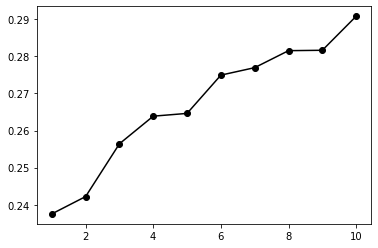

In [84]:
print(np.quantile(res.tolist(), [0,0.25,0.5,0.75,1]))
plt.plot(range(1, len(res)+1), sorted(res.tolist()), '-ok')

In [89]:
# df of DMSO vs treatment for each condition
d = pd.DataFrame(data=r.values(), index=r.keys(), columns=['ERCC pseudo-counts','var'])
d['Experiments'] = d.index
d

,ERCC pseudo-counts,var,Experiments
DMSO,0.268615,0.016713,DMSO
Mebendazole,0.265462,0.016375,Mebendazole


ERCC scaling factors
* treatment vs DMSO should be different
* protein level in treatment < DMSO: more ERCC transcripts in treatment than DMSO (less RNA transcripts)
* scaling factors: treatment > DMSO - ERCC counts/scaling factors in treatment should be higher

v1


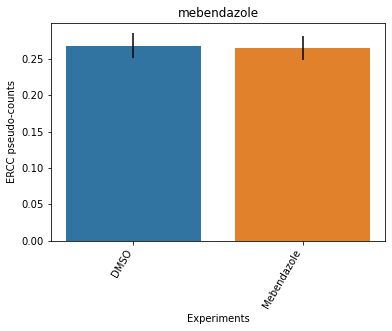

Saved to ../results/slamseq_mebendazole_v1/plots/mebendazole_v1_scaling_fact_with_conf.pdf


In [91]:
version = project.replace("_", " ").split(" ")[-1]
print(version)
createDir(res_dir+"/plots/")

# barplot of DMSO vs VHL for each condition
sns.barplot(x="Experiments", y="ERCC pseudo-counts", data=d, ci=None, )
plt.errorbar(x=range(0,len(d)), y=d['ERCC pseudo-counts'],
             yerr=d['var'], fmt='none', ecolor="black")
plt.xticks(rotation=60, ha='right')
plt.title(project.replace("_", " ").split(" v")[0])

plt.savefig(res_dir+"plots/"+project+"_scaling_fact_with_conf.pdf", bbox_inches="tight")
plt.show()
print("Saved to "+res_dir+"plots/"+project+"_scaling_fact_with_conf.pdf")

__save average ERCC scaling factors__

In [92]:
d

,ERCC pseudo-counts,var,Experiments
DMSO,0.268615,0.016713,DMSO
Mebendazole,0.265462,0.016375,Mebendazole


In [93]:
# save avg ERCC pseudocounts
res_dir = "../results/slamseq_"+project+"/"
d.to_csv(res_dir+project+"_scaling_factors_avg.csv", header=True, index=True)

## save the data to our bucket

In [94]:
project

'mebendazole_v1'

In [95]:
! gsutil -m cp ../../data/slamseq_$project/res/filter/* gs://amlproject/RNA/slamseq/$project/res/filter/ 
! gsutil -m cp ../../data/slamseq_$project/res/snp/* gs://amlproject/RNA/slamseq/$project/res/snp/ 
! gsutil -m cp ../../data/slamseq_$project/res/count/* gs://amlproject/RNA/slamseq/$project/res/count/

Copying file://../../data/slamseq_mebendazole_v1/res/filter/ERCC_mr522-MV411-DMSO-r1_filtered.bam [Content-Type=application/octet-stream]...
Copying file://../../data/slamseq_mebendazole_v1/res/filter/ERCC_mr522-MV411-DMSO-r1_filtered.bam.bed [Content-Type=application/octet-stream]...
Copying file://../../data/slamseq_mebendazole_v1/res/filter/ERCC_mr523-MV411-DMSO-r2_filtered.bam [Content-Type=application/octet-stream]...
Copying file://../../data/slamseq_mebendazole_v1/res/filter/ERCC_mr523-MV411-DMSO-r2_filtered.bam.bed [Content-Type=application/octet-stream]...
Copying file://../../data/slamseq_mebendazole_v1/res/filter/ERCC_mr524-MV411-DMSO-r3_filtered.bam [Content-Type=application/octet-stream]...
Copying file://../../data/slamseq_mebendazole_v1/res/filter/ERCC_mr524-MV411-DMSO-r3_filtered.bam.bed [Content-Type=application/octet-stream]...
Copying file://../../data/slamseq_mebendazole_v1/res/filter/ERCC_mr525-MV411-DMSO-r4_filtered.bam [Content-Type=application/octet-stream]...
C

# SLAM-seq
All SLAM-seq assays were performed at 60-70% confluency for adherent cells or
60% of the maximum cell density counted on a hemocytometer for suspension cells. 5-7h
prior to each assay, growth medium was aspirated and replaced. Unless stated otherwise,
cells were pre-treated with indicated small molecule inhibitors or 100µM IAA for 30 min
to pre-establish full target inhibition or degradation. Newly synthesized RNA was labeled
for indicated time spans (45 min or 60 min) at a final concentration of 100µM 4-
thiouridine (4sU, Carbosynth). Adherent cells were harvested by direct snap-freezing of
plates on dry ice. Suspension cells were spun down and immediately snap-frozen. RNA
extraction was performed using the RNeasy Plus Mini Kit (Qiagen). 

Total RNA was subjected to alkylation by iodoacetamide (Sigma, 10mM) for 15 min and RNA was repurified by ethanol precipitation. 500ng alkylated RNA were used as input for generating
3’-end mRNA sequencing libraries using a commercially available kit (QuantSeq 3′
mRNA-Seq Library Prep Kit FWD for Illumina and PCR Add-on Kit for Illumina,
Lexogen). Deep sequencing was performed using HiSeq1500 and HiSeq2500 platforms
(Illumina).

## make count files

In [96]:
project = project
res_folder = "res"
location = "../../data/slamseq_"+project+"/"+res_folder+"/"+"count/"
print(location)

../../data/slamseq_mebendazole_v1/res/count/


In [97]:
# remove genes that have very low counts
mincount_toremove=5

# remove genes that have a variance of 0 across all samples (these we really want to remove)
# genes that have values of 0,1,2 everywhere
minvar_toremove=0

<li>readcounts: total counts of every transscript (output of slamdunk algorithm
<li>tccounts: t to c converted RNA transcripts

In [98]:
%%time

# all genes (not just protein coding)
readcounts, tccounts = rna.readFromSlamdunk(loc=location, 
                                            minvar_toremove=minvar_toremove, 
                                            mincount_toremove=mincount_toremove,
                                            verbose=False)

found 10 files:dict_keys(['mr522-MV411-DMSO-r1_tcount', 'mr523-MV411-DMSO-r2_tcount', 'mr524-MV411-DMSO-r3_tcount', 'mr525-MV411-DMSO-r4_tcount', 'mr526-MV411-DMSO-r5_tcount', 'mr527-MV411-Mebendazole-r1_tcount', 'mr528-MV411-Mebendazole-r2_tcount', 'mr529-MV411-Mebendazole-r3_tcount', 'mr530-MV411-Mebendazole-r4_tcount', 'mr531-MV411-Mebendazole-r5_tcount'])
mr522-MV411-DMSO-r1
mr523-MV411-DMSO-r2
mr524-MV411-DMSO-r3
mr525-MV411-DMSO-r4
mr526-MV411-DMSO-r5
mr527-MV411-Mebendazole-r1
mr528-MV411-Mebendazole-r2
mr529-MV411-Mebendazole-r3
mr530-MV411-Mebendazole-r4
mr531-MV411-Mebendazole-r5
downloading gene names from biomart
1750 count not be parsed... we don't have all genes already
downloading gene names from biomart
1750 count not be parsed... we don't have all genes already
CPU times: user 1min 29s, sys: 512 ms, total: 1min 29s
Wall time: 2min 16s


Check for duplicate gene rows

In [99]:
def dedup_df_genes(df):
    ''' sum rows with the same gene index and remove duplicate '''
    if df.shape[0] != len(df.index.drop_duplicates()):
        print("Duplicate gene rows!")
        print("{} rows | {} unique genes".format(df.shape[0], len(df.index.drop_duplicates())))
        print("Summing of duplicate gene rows.")
        
    # sum duplicate rows, same row order
    duplicate_genes = df.index[df.index.duplicated()].tolist()
    df = df.groupby(df.index).sum().loc[df.index.drop_duplicates()]
    if df.shape[0] != len(df.index.drop_duplicates()):
        raise ValueError(
            "Cannot collapse duplicate gene rows."
        )
    
    return df, duplicate_genes

In [100]:
readcounts, duplicate_genes = dedup_df_genes(readcounts)
tccounts, duplicate_genes = dedup_df_genes(tccounts)

if readcounts.shape != tccounts.shape:
    raise ValueError("readcounts and tccounts not the same dimensions: {} | {}".format(readcounts.shape, tccounts.shape))

Duplicate gene rows!
14323 rows | 14292 unique genes
Summing of duplicate gene rows.
Duplicate gene rows!
14323 rows | 14292 unique genes
Summing of duplicate gene rows.


## make density plot

In [101]:
res_dir = "../results/slamseq_{}/".format(project)
print(res_dir)
createDir(res_dir)

../results/slamseq_mebendazole_v1/


In [102]:
# sort cols
col = tccounts.columns.tolist()
col.sort()
tccounts = tccounts[col]

In [103]:
# sort cols
col = readcounts.columns.tolist()
col.sort()
readcounts = readcounts[col]

In [104]:
print(readcounts.shape)
readcounts.iloc[:2]

(14292, 10)


,mr522-MV411-DMSO-r1_tcount,mr523-MV411-DMSO-r2_tcount,mr524-MV411-DMSO-r3_tcount,mr525-MV411-DMSO-r4_tcount,mr526-MV411-DMSO-r5_tcount,mr527-MV411-Mebendazole-r1_tcount,mr528-MV411-Mebendazole-r2_tcount,mr529-MV411-Mebendazole-r3_tcount,mr530-MV411-Mebendazole-r4_tcount,mr531-MV411-Mebendazole-r5_tcount
A1BG,0,0,1,5,1,0,0,2,3,0
NAT1,95,109,87,272,151,142,173,156,179,87


read counts that are t $\rightarrow$ c converted (actively transcribed)
* most at 0 = most are not transcribed
* a lot at 1 or everything at 0 is weird

13451


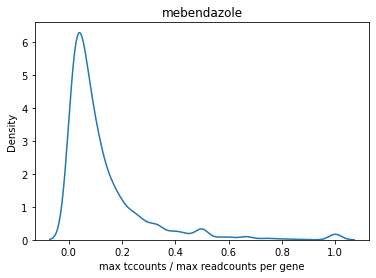

In [105]:
# what is the average of highly transcribed genes?
# tccounts/readcounts where sum of readcounts in all samples > 30 
a = tccounts[readcounts.sum(1)>30] / readcounts[readcounts.sum(1)>30]
a = a.fillna(0)
a = a.max(1).tolist() # max val per gene
a.sort()
print(len(a))
sns.kdeplot(a)
plt.xlabel("max tccounts / max readcounts per gene")
plt.title(project.replace("_", " ").split(" v")[0])

plt.savefig(res_dir+'plots/'+project+'_tccounts_readcounts_density.pdf', dpi=300, bbox_inches="tight")
plt.show()

In [106]:
np.median(a)

0.07432432432432433

In [107]:
# Save counts to csv
counts_file_prefix = project+'_'+str(minvar_toremove)+'_'+str(mincount_toremove)

readcounts.to_csv(res_dir+counts_file_prefix+"_readcounts.csv",index=True, index_label="GENE")
print("Saved readcounts to: {}".format(res_dir+counts_file_prefix+"_readcounts.csv"))

tccounts.to_csv(res_dir+counts_file_prefix+"_tccounts.csv",index=True, index_label="GENE")
print("Saved tccounts to: {}".format(res_dir+counts_file_prefix+"_tccounts.csv"))

Saved readcounts to: ../results/slamseq_mebendazole_v1/mebendazole_v1_0_5_readcounts.csv
Saved tccounts to: ../results/slamseq_mebendazole_v1/mebendazole_v1_0_5_tccounts.csv


## make more dfs (mean, median, etc.)

In [108]:
readcounts.iloc[:1]

,mr522-MV411-DMSO-r1_tcount,mr523-MV411-DMSO-r2_tcount,mr524-MV411-DMSO-r3_tcount,mr525-MV411-DMSO-r4_tcount,mr526-MV411-DMSO-r5_tcount,mr527-MV411-Mebendazole-r1_tcount,mr528-MV411-Mebendazole-r2_tcount,mr529-MV411-Mebendazole-r3_tcount,mr530-MV411-Mebendazole-r4_tcount,mr531-MV411-Mebendazole-r5_tcount
A1BG,0,0,1,5,1,0,0,2,3,0


In [109]:
print("Genes with highest read counts per sample.")
for column in readcounts:
    print(column.split("MV411-")[1].split("_")[0] +": "+ str(readcounts[column].idxmax()))

Genes with highest read counts per sample.
DMSO-r1: RPL13AP5
DMSO-r2: RPL13AP5
DMSO-r3: RPL13AP5
DMSO-r4: RPL13AP5
DMSO-r5: RPL13AP5
Mebendazole-r1: RPL13AP5
Mebendazole-r2: RPL13AP5
Mebendazole-r3: RPL13AP5
Mebendazole-r4: RPL13AP5
Mebendazole-r5: RPL13AP5


In [110]:
readcounts.idxmax().value_counts()

RPL13AP5    10
dtype: int64

In [111]:
tccounts.columns

Index(['mr522-MV411-DMSO-r1_tcount', 'mr523-MV411-DMSO-r2_tcount',
       'mr524-MV411-DMSO-r3_tcount', 'mr525-MV411-DMSO-r4_tcount',
       'mr526-MV411-DMSO-r5_tcount', 'mr527-MV411-Mebendazole-r1_tcount',
       'mr528-MV411-Mebendazole-r2_tcount',
       'mr529-MV411-Mebendazole-r3_tcount',
       'mr530-MV411-Mebendazole-r4_tcount',
       'mr531-MV411-Mebendazole-r5_tcount'],
      dtype='object')

In [112]:
print(set([i.split('-', 1)[-1].rpartition("-")[0] for i in tccounts.columns]))
print(tccounts.columns[0].split('-', 1))
print(tccounts.columns[0].split('-', 1)[-1].rpartition("-")[0])
list(dict.fromkeys([r.split("-", 1)[1].split("_")[0].rsplit("-", 1)[0] for r in tccounts.columns]))

{'MV411-Mebendazole', 'MV411-DMSO'}
['mr522', 'MV411-DMSO-r1_tcount']
MV411-DMSO


['MV411-DMSO', 'MV411-Mebendazole']

In [113]:
# get mean counts per condition
mtccounts = pd.DataFrame()
mreadcounts = pd.DataFrame()
# conditions maintaing column order
for i in list(dict.fromkeys([i.split('-', 1)[-1].rpartition("-")[0] for i in tccounts.columns])):
    print(i)
    mtccounts[i] = tccounts[[v for v in tccounts.columns if i in v]].mean(1)
    mreadcounts[i] = readcounts[[v for v in readcounts.columns if i in v]].mean(1)

# save mean counts files
mtccounts.to_csv(res_dir+counts_file_prefix+"_mean_tccounts.csv", index=True, index_label="GENE")
mreadcounts.to_csv(res_dir+counts_file_prefix+"_mean_readcounts.csv", index=True, index_label="GENE")

MV411-DMSO
MV411-Mebendazole


In [114]:
# get median counts per condition
mtccounts = pd.DataFrame()
mreadcounts = pd.DataFrame()
# conditions maintaing column order
for i in list(dict.fromkeys([i.split('-', 1)[-1].rpartition("-")[0] for i in tccounts.columns])):
    print(i)
    mtccounts[i] = tccounts[[v for v in tccounts.columns if i in v]].median(1)
    mreadcounts[i] = readcounts[[v for v in readcounts.columns if i in v]].median(1)

# save median counts files
mtccounts.to_csv(res_dir+counts_file_prefix+"_median_tccounts.csv", index=True, index_label="GENE")
mreadcounts.to_csv(res_dir+counts_file_prefix+"_median_readcounts.csv", index=True, index_label="GENE")

MV411-DMSO
MV411-Mebendazole


In [115]:
(tccounts/readcounts).fillna(0).iloc[:2]

,mr522-MV411-DMSO-r1_tcount,mr523-MV411-DMSO-r2_tcount,mr524-MV411-DMSO-r3_tcount,mr525-MV411-DMSO-r4_tcount,mr526-MV411-DMSO-r5_tcount,mr527-MV411-Mebendazole-r1_tcount,mr528-MV411-Mebendazole-r2_tcount,mr529-MV411-Mebendazole-r3_tcount,mr530-MV411-Mebendazole-r4_tcount,mr531-MV411-Mebendazole-r5_tcount
A1BG,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
NAT1,0.157895,0.06422,0.137931,0.091912,0.086093,0.035211,0.075145,0.044872,0.111732,0.114943


In [116]:
# Save tccounts/readcounts file
(tccounts/readcounts).fillna(0).to_csv(res_dir+counts_file_prefix+"_tccounts_per_readcounts.csv")
print("Saved tccounts/readcounts to: {}".format(res_dir+counts_file_prefix+"_tccounts_per_readcounts.csv"))

Saved tccounts/readcounts to: ../results/slamseq_mebendazole_v1/mebendazole_v1_0_5_tccounts_per_readcounts.csv


## looking at similarity accross replicates

we have some outliers, else it seems to make some sense and on average, to be extremelly similar!

In [117]:
# conditions
[i.split('-', 1)[-1].rpartition("-")[0] for i in tccounts.columns]

['MV411-DMSO',
 'MV411-DMSO',
 'MV411-DMSO',
 'MV411-DMSO',
 'MV411-DMSO',
 'MV411-Mebendazole',
 'MV411-Mebendazole',
 'MV411-Mebendazole',
 'MV411-Mebendazole',
 'MV411-Mebendazole']

### save plots to pdf

Replicate similarity plot saved to: ../results/slamseq_mebendazole_v1/plots/mebendazole_v1_similarity_replicates_sorted_tccounts.pdf


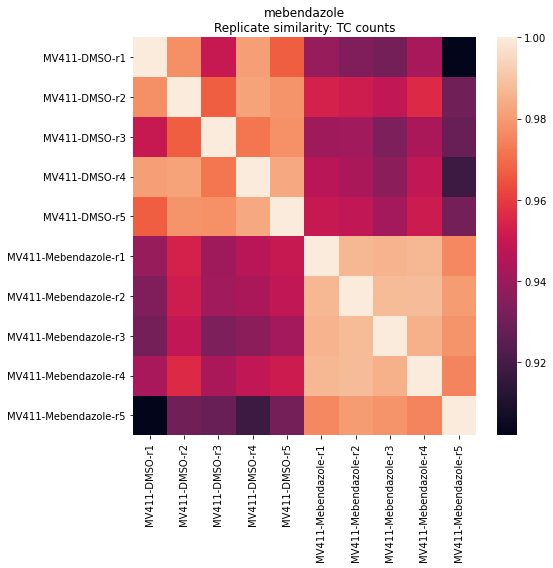

In [120]:
%matplotlib inline
import matplotlib.font_manager

font_settings = {
    "family" : "sans-serif",
    "size" : 10
}
plt.rc("font", **font_settings)

# tccounts
fig, ax = plt.subplots(figsize=(8,8))
sns.heatmap(tccounts.corr(),
            # condition w/ rep label
            xticklabels=[i.split('-', 1)[-1].rpartition("_")[0] for i in tccounts.columns],
            yticklabels=[i.split('-', 1)[-1].rpartition("_")[0] for i in tccounts.columns],
            ax=ax, cmap="rocket")#, vmin=0.9, vmax=1)
plt.title(project.replace("_", " ").split(" v")[0]+"\n"+"Replicate similarity: TC counts")
plt.tight_layout()

plt.savefig(res_dir+'plots/'+project+'_similarity_replicates_sorted_tccounts.pdf', dpi=300)

print("Replicate similarity plot saved to: {}".format(res_dir+'plots/'+project+
                                                      '_similarity_replicates_sorted_tccounts.pdf'))

Replicate similarity plot saved to: ../results/slamseq_mebendazole_v1/plots/mebendazole_v1_similarity_replicates_sorted_readcounts.pdf


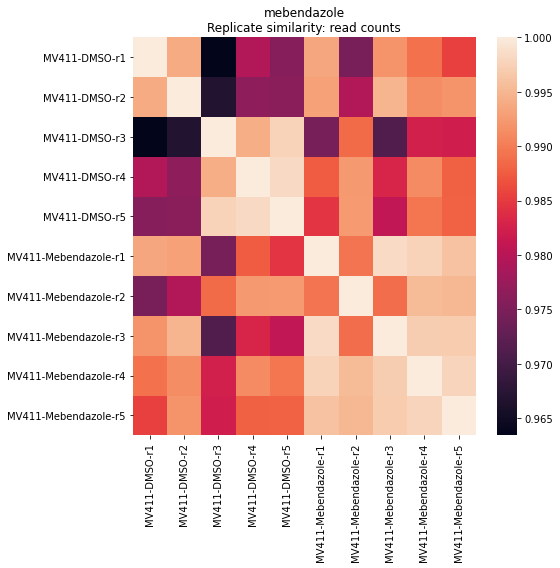

In [122]:
%matplotlib inline

# readcounts
fig, ax = plt.subplots(figsize=(8,8))
sns.heatmap(readcounts.corr(), 
            # condition w/ rep label
            xticklabels=[i.split('-', 1)[-1].rpartition("_")[0] for i in tccounts.columns],
            yticklabels=[i.split('-', 1)[-1].rpartition("_")[0] for i in tccounts.columns],
            ax=ax) #, vmin=0.985, vmax=1)
plt.title(project.replace("_", " ").split(" v")[0]+"\n"+"Replicate similarity: read counts")
plt.tight_layout()

plt.savefig(res_dir+'plots/'+project+'_similarity_replicates_sorted_readcounts.pdf', dpi=300)

print("Replicate similarity plot saved to: {}".format(res_dir+'plots/'+project+
                                                      '_similarity_replicates_sorted_readcounts.pdf'))

# DESeq analysis

In [123]:
res_dir = "../results/slamseq_{}/".format(project)
print(res_dir)

../results/slamseq_mebendazole_v1/


In [124]:
readcounts.iloc[:1]

,mr522-MV411-DMSO-r1_tcount,mr523-MV411-DMSO-r2_tcount,mr524-MV411-DMSO-r3_tcount,mr525-MV411-DMSO-r4_tcount,mr526-MV411-DMSO-r5_tcount,mr527-MV411-Mebendazole-r1_tcount,mr528-MV411-Mebendazole-r2_tcount,mr529-MV411-Mebendazole-r3_tcount,mr530-MV411-Mebendazole-r4_tcount,mr531-MV411-Mebendazole-r5_tcount
A1BG,0,0,1,5,1,0,0,2,3,0


In [125]:
# make genes col
readcounts["genes"] = readcounts.index
readcounts = readcounts.reset_index(drop=True)

tccounts["genes"] = tccounts.index
tccounts = tccounts.reset_index(drop=True)

In [126]:
readcounts.iloc[:1]

,mr522-MV411-DMSO-r1_tcount,mr523-MV411-DMSO-r2_tcount,mr524-MV411-DMSO-r3_tcount,mr525-MV411-DMSO-r4_tcount,mr526-MV411-DMSO-r5_tcount,mr527-MV411-Mebendazole-r1_tcount,mr528-MV411-Mebendazole-r2_tcount,mr529-MV411-Mebendazole-r3_tcount,mr530-MV411-Mebendazole-r4_tcount,mr531-MV411-Mebendazole-r5_tcount,genes
0,0,0,1,5,1,0,0,2,3,0,A1BG


In [127]:
[i.split('-', 1)[-1].split("_tc")[0] for i in tccounts.columns]

['MV411-DMSO-r1',
 'MV411-DMSO-r2',
 'MV411-DMSO-r3',
 'MV411-DMSO-r4',
 'MV411-DMSO-r5',
 'MV411-Mebendazole-r1',
 'MV411-Mebendazole-r2',
 'MV411-Mebendazole-r3',
 'MV411-Mebendazole-r4',
 'MV411-Mebendazole-r5',
 'genes']

In [129]:
# col info
cols = tccounts.columns[:-1]
experiments = [x.split("-", 1)[1].rsplit("-", 1)[0] for x in cols]
conds = [x.split("-", 2)[-1].rsplit("-", 1)[0] for x in cols]
time = ["1h" for x in conds]
treatment = [x.split("_")[0] for x in conds]
rep = [x.split("_")[-2].split("-")[-1] for x in cols]
drop = [False for x in cols]
#[True if any(sample in x for sample in drop_samples) else False for x in cols]

# experimental design
exp_design = pd.DataFrame(list(zip(cols, experiments, conds, time, treatment, rep, drop)), 
                          columns=["col", "experiment", "cond", "time", "treatment", "rep", "drop"])

exp_design

,col,experiment,cond,time,treatment,rep,drop
0,mr522-MV411-DMSO-r1_tcount,MV411-DMSO,DMSO,1h,DMSO,r1,False
1,mr523-MV411-DMSO-r2_tcount,MV411-DMSO,DMSO,1h,DMSO,r2,False
2,mr524-MV411-DMSO-r3_tcount,MV411-DMSO,DMSO,1h,DMSO,r3,False
3,mr525-MV411-DMSO-r4_tcount,MV411-DMSO,DMSO,1h,DMSO,r4,False
4,mr526-MV411-DMSO-r5_tcount,MV411-DMSO,DMSO,1h,DMSO,r5,False
5,mr527-MV411-Mebendazole-r1_tcount,MV411-Mebendazole,Mebendazole,1h,Mebendazole,r1,False
6,mr528-MV411-Mebendazole-r2_tcount,MV411-Mebendazole,Mebendazole,1h,Mebendazole,r2,False
7,mr529-MV411-Mebendazole-r3_tcount,MV411-Mebendazole,Mebendazole,1h,Mebendazole,r3,False
8,mr530-MV411-Mebendazole-r4_tcount,MV411-Mebendazole,Mebendazole,1h,Mebendazole,r4,False
9,mr531-MV411-Mebendazole-r5_tcount,MV411-Mebendazole,Mebendazole,1h,Mebendazole,r5,False


## make design matrix

In [132]:
# DMSO vs Mebendazole
version = "v1"
var_name = "treatment"
var1 = "DMSO"
var2 = "Mebendazole"

In [130]:
# tccounts
tccountsGene = tccounts[tccounts.columns[:-1]]

# readcounts
readcountsGene = readcounts[readcounts.columns[:-1]]

In [134]:
# get just var data
# remove dropped reps
var1_cols = [1 if (exp_design.iloc[idx][var_name] == var1) and (exp_design.iloc[idx]["drop"] == False) 
             else 0 for idx in range(exp_design.shape[0])]

var2_cols = [1 if (exp_design.iloc[idx]["treatment"] == var2) and (exp_design.iloc[idx]["drop"] == False) 
             else 0 for idx in range(exp_design.shape[0])]

var_cols = [x+y for x,y in zip(var1_cols, var2_cols)]

In [135]:
# all columns
design = pd.DataFrame(index= [i.replace("-",".") for i in tccountsGene.columns], 
                      columns=[var1, var2], 
                      data=np.array([var1_cols, var2_cols], dtype=bool).T)

In [136]:
design

,DMSO,Mebendazole
mr522.MV411.DMSO.r1_tcount,True,False
mr523.MV411.DMSO.r2_tcount,True,False
mr524.MV411.DMSO.r3_tcount,True,False
mr525.MV411.DMSO.r4_tcount,True,False
mr526.MV411.DMSO.r5_tcount,True,False
mr527.MV411.Mebendazole.r1_tcount,False,True
mr528.MV411.Mebendazole.r2_tcount,False,True
mr529.MV411.Mebendazole.r3_tcount,False,True
mr530.MV411.Mebendazole.r4_tcount,False,True
mr531.MV411.Mebendazole.r5_tcount,False,True


In [137]:
# genes as first column
tccountsGene = tccounts[['genes']+list(tccountsGene.columns)]
readcountsGene = readcounts[['genes']+list(readcountsGene.columns)]

## ERCC samplewise scaled

In [138]:
scaling="ERCCsamplewise"

__make DESeq object__

In [139]:
# tccounts DESeq gene object
# just var data
deseqGene_tc = pyDESeq2.pyDESeq2(count_matrix=tccountsGene[tccountsGene.columns[np.array([1]+var_cols, bool)]], 
                                 design_matrix=design[np.array(var_cols, bool)],
                                 design_formula="~{} - {}".format(var1, var2),
                                 gene_column="genes")

you need to have R installed with the DESeq2 library installed
3.4.5


In [140]:
# readcounts DESeq gene object
deseqGene_read = pyDESeq2.pyDESeq2(count_matrix=readcountsGene[readcountsGene.columns[np.array([1]+var_cols, bool)]], 
                                   design_matrix=design[np.array(var_cols, bool)],
                                   design_formula="~{} - {}".format(var1, var2),
                                   gene_column="genes")

you need to have R installed with the DESeq2 library installed
3.4.5


__estimate & modify size factors__

In [141]:
# tccounts
deseqGene_tc.run_estimate_size_factors(geoMeans = np.exp(np.mean(np.log(
    readcounts[tccountsGene.columns[[False]+design[var1].tolist()]].values+1), 1)))

# readcounts
deseqGene_read.run_estimate_size_factors()

In [142]:
# read in ERCC pseudocounts
res = pd.read_csv(res_dir+"/"+project+"_scaling_factors.csv", index_col=0, header=None, squeeze=True)

# select var values
res = res[np.array(var_cols, dtype=bool)]
res

0
ERCC_mr522-MV411-DMSO-r1_filtered.bam           0.263862
ERCC_mr523-MV411-DMSO-r2_filtered.bam           0.242204
ERCC_mr524-MV411-DMSO-r3_filtered.bam           0.264608
ERCC_mr525-MV411-DMSO-r4_filtered.bam           0.281616
ERCC_mr526-MV411-DMSO-r5_filtered.bam           0.290784
ERCC_mr527-MV411-Mebendazole-r1_filtered.bam    0.281510
ERCC_mr528-MV411-Mebendazole-r2_filtered.bam    0.276935
ERCC_mr529-MV411-Mebendazole-r3_filtered.bam    0.237529
ERCC_mr530-MV411-Mebendazole-r4_filtered.bam    0.274919
ERCC_mr531-MV411-Mebendazole-r5_filtered.bam    0.256419
Name: 1, dtype: float64

__modify size factors__
<br>VHL size factor * adjusted VHL res (VHL res per sample / average DMSO res)

In [143]:
# tccounts
sizeFact = deseqGene_tc.getSizeFactors()
sizeFact[sum(var1_cols):] = sizeFact[sum(var1_cols):] * (res[[i for i in res.index if '-'+str(var2) in i]].values/
                                                         res[[i for i in res.index if '-'+str(var1) in i]].values.mean())
deseqGene_tc.setSizeFactors(sizeFact)

In [144]:
# readcounts
sizeFact = deseqGene_read.getSizeFactors()
sizeFact[sum(var1_cols):] = sizeFact[sum(var1_cols):] * (res[[i for i in res.index if '-'+str(var2) in i]].values/
                                                         res[[i for i in res.index if '-'+str(var1) in i]].values.mean())
deseqGene_read.setSizeFactors(sizeFact)

__run it__

In [145]:
%%time

# tccounts
deseqGene_tc.run_deseq()
deseqGene_tc.get_deseq_result()

resGene_tc = deseqGene_tc.deseq_result
resGene_tc.pvalue = np.nan_to_num(np.array(resGene_tc.pvalue), 1)
resGene_tc.log2FoldChange = np.nan_to_num(np.array(resGene_tc.log2FoldChange), 0)
resGene_tc.log2FoldChange = -resGene_tc.log2FoldChange
resGene_tc["gene_id"] = resGene_tc.genes

R[write to console]: using pre-existing size factors

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: final dispersion estimates

R[write to console]: fitting model and testing



CPU times: user 6.97 s, sys: 924 ms, total: 7.9 s
Wall time: 6.47 s


In [146]:
%%time

#readcounts
deseqGene_read.run_deseq()
deseqGene_read.get_deseq_result()

resGene_read = deseqGene_read.deseq_result
resGene_read.pvalue = np.nan_to_num(np.array(resGene_read.pvalue), 1)
resGene_read.log2FoldChange = np.nan_to_num(np.array(resGene_read.log2FoldChange), 0)
resGene_read.log2FoldChange = -resGene_read.log2FoldChange
resGene_read["gene_id"] = resGene_read.genes

R[write to console]: using pre-existing size factors

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: final dispersion estimates

R[write to console]: fitting model and testing



CPU times: user 7.38 s, sys: 1.75 s, total: 9.13 s
Wall time: 5.67 s


__save DESeq results__

In [147]:
# check all genes are in output
if not tccounts.shape[0] == resGene_tc.shape[0]:
    raise ValueError("Results do not have the same number of genes as counts.")

if not tccounts["genes"].isin(resGene_tc["genes"]).all():
    raise ValueError("Results do not have the same genes as counts.")

In [148]:
"{}_{}_deseq_tccounts.csv".format(project, "_".join(
    filter(None, [var1, var2, scaling, str(minvar_toremove), str(mincount_toremove)])))

'mebendazole_v1_DMSO_Mebendazole_ERCCsamplewise_0_5_deseq_tccounts.csv'

In [149]:
# tccounts
deseq_res_file = "{}_{}_deseq_tccounts.csv".format(project, "_".join(
    filter(None, [var1, var2, scaling, str(minvar_toremove), str(mincount_toremove)])))
resGene_tc.to_csv("{}/{}".format(res_dir, deseq_res_file), index=False)

print("Saved DESeq results to: {}".format(deseq_res_file))

Saved DESeq results to: mebendazole_v1_DMSO_Mebendazole_ERCCsamplewise_0_5_deseq_tccounts.csv


In [150]:
# readcounts
deseq_res_file = "{}_{}_deseq_readcounts.csv".format(project, "_".join(
    filter(None, [var1, var2, scaling, str(minvar_toremove), str(mincount_toremove)])))
resGene_read.to_csv("{}/{}".format(res_dir, deseq_res_file), index=False)

print("Saved DESeq results to: {}".format(deseq_res_file))

Saved DESeq results to: mebendazole_v1_DMSO_Mebendazole_ERCCsamplewise_0_5_deseq_readcounts.csv


## Unscaled

In [151]:
scaling = None

__make DESeq object__

In [152]:
# tccounts DESeq gene object
# just var data
deseqGene_tc = pyDESeq2.pyDESeq2(count_matrix=tccountsGene[tccountsGene.columns[np.array([1]+var_cols, bool)]], 
                                 design_matrix=design[np.array(var_cols, bool)],
                                 design_formula="~{} - {}".format(var1, var2),
                                 gene_column="genes")

you need to have R installed with the DESeq2 library installed
3.4.5


In [153]:
# readcounts DESeq gene object
deseqGene_read = pyDESeq2.pyDESeq2(count_matrix=readcountsGene[readcountsGene.columns[np.array([1]+var_cols, bool)]], 
                                   design_matrix=design[np.array(var_cols, bool)],
                                   design_formula="~{} - {}".format(var1, var2),
                                   gene_column="genes")

you need to have R installed with the DESeq2 library installed
3.4.5


__estimate size factors__

In [154]:
# tccounts
deseqGene_tc.run_estimate_size_factors(geoMeans = np.exp(np.mean(np.log(
    readcounts[tccountsGene.columns[[False]+design[var1].tolist()]].values+1), 1)))

# readcounts
deseqGene_read.run_estimate_size_factors()

__run it__

In [157]:
%%time

# tccounts
deseqGene_tc.run_deseq()
deseqGene_tc.get_deseq_result()

resGene_tc = deseqGene_tc.deseq_result
resGene_tc.pvalue = np.nan_to_num(np.array(resGene_tc.pvalue), 1)
resGene_tc.log2FoldChange = np.nan_to_num(np.array(resGene_tc.log2FoldChange), 0)
resGene_tc.log2FoldChange = -resGene_tc.log2FoldChange
resGene_tc["gene_id"] = resGene_tc.genes

R[write to console]: using pre-existing size factors

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: final dispersion estimates

R[write to console]: fitting model and testing



CPU times: user 6.26 s, sys: 884 ms, total: 7.15 s
Wall time: 5.28 s


In [158]:
%%time

#readcounts
deseqGene_read.run_deseq()
deseqGene_read.get_deseq_result()

resGene_read = deseqGene_read.deseq_result
resGene_read.pvalue = np.nan_to_num(np.array(resGene_read.pvalue), 1)
resGene_read.log2FoldChange = np.nan_to_num(np.array(resGene_read.log2FoldChange), 0)
resGene_read.log2FoldChange = -resGene_read.log2FoldChange
resGene_read["gene_id"] = resGene_read.genes

R[write to console]: using pre-existing size factors

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: final dispersion estimates

R[write to console]: fitting model and testing



CPU times: user 6.9 s, sys: 1.75 s, total: 8.65 s
Wall time: 5.28 s


__save DESeq results__

In [161]:
# check all genes are in output
if not tccounts.shape[0] == resGene_tc.shape[0]:
    raise ValueError("Results do not have the same number of genes as counts.")

if not tccounts["genes"].isin(resGene_tc["genes"]).all():
    raise ValueError("Results do not have the same genes as counts.")

In [162]:
"{}_{}_deseq_tccounts.csv".format(project, "_".join(
    filter(None, [var1, var2, scaling, str(minvar_toremove), str(mincount_toremove)])))

'mebendazole_v1_DMSO_Mebendazole_0_5_deseq_tccounts.csv'

In [163]:
# tccounts
deseq_res_file = "{}_{}_deseq_tccounts.csv".format(project, "_".join(
    filter(None, [var1, var2, scaling, str(minvar_toremove), str(mincount_toremove)])))
resGene_tc.to_csv("{}/{}".format(res_dir, deseq_res_file), index=False)

print("Saved DESeq results to: {}".format(deseq_res_file))

Saved DESeq results to: mebendazole_v1_DMSO_Mebendazole_0_5_deseq_tccounts.csv


In [164]:
# readcounts
deseq_res_file = "{}_{}_deseq_readcounts.csv".format(project, "_".join(
    filter(None, [var1, var2, scaling, str(minvar_toremove), str(mincount_toremove)])))
resGene_read.to_csv("{}/{}".format(res_dir, deseq_res_file), index=False)

print("Saved DESeq results to: {}".format(deseq_res_file))

Saved DESeq results to: mebendazole_v1_DMSO_Mebendazole_0_5_deseq_readcounts.csv


# Plots

In [165]:
scaling = None

In [166]:
deseq_files = ! ls $res_dir/*deseq*
deseq_files

['../results/slamseq_mebendazole_v1//mebendazole_v1_DMSO_Mebendazole_0_5_deseq_readcounts.csv',
 '../results/slamseq_mebendazole_v1//mebendazole_v1_DMSO_Mebendazole_0_5_deseq_tccounts.csv',
 '../results/slamseq_mebendazole_v1//mebendazole_v1_DMSO_Mebendazole_ERCCsamplewise_0_5_deseq_readcounts.csv',
 '../results/slamseq_mebendazole_v1//mebendazole_v1_DMSO_Mebendazole_ERCCsamplewise_0_5_deseq_tccounts.csv']

In [167]:
res_dfs = [pd.read_csv(file, header=[0], index_col=None, squeeze=True) for file in deseq_files]

In [168]:
res_dfs[0].head()

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,genes,gene_id
0,0.961775,-0.481791,1.333388,0.361329,0.717854,NaN,A1BG,A1BG
1,137.931838,-0.152719,0.168504,0.906322,0.364765,0.705445,NAT1,NAT1
2,349.391999,0.091060,0.087859,-1.036432,0.300001,0.656839,AAMP,AAMP
3,243.033207,-0.277504,0.122509,2.265178,0.023502,0.211960,AARS1,AARS1
4,70.333897,-0.222404,0.166310,1.337286,0.181129,0.539089,ABAT,ABAT


## whisker plots

In [169]:
%matplotlib inline

In [193]:
cond = "1h"

__using tc counts__

In [170]:
# Choose file/dataset
df_idx = 1
print(deseq_files[df_idx])
read_type = os.path.basename(deseq_files[df_idx]).split(".")[0].split("_")[-1]
scaling = "ERCCsamplewise" if "ERCCsamplewise" in deseq_files[df_idx] else None
print(scaling)

../results/slamseq_mebendazole_v1//mebendazole_v1_DMSO_Mebendazole_0_5_deseq_tccounts.csv
None


In [187]:
# DESeq results
res = res_dfs[df_idx]
print(res.shape)

(14292, 8)


__get CRCs__

In [179]:
# getting the crcs
crcs = h.fileToList("../data/CRCs_31.txt")
crcs

['CEBPA',
 'E2F3',
 'FLI1',
 'FOSL2',
 'GFI1',
 'HHEX',
 'IRF8',
 'LYL1',
 'MEF2C',
 'MEF2D',
 'MEIS1',
 'MYB',
 'PLAGL2',
 'RUNX1',
 'RUNX2',
 'RXRA',
 'SP1',
 'SPI1',
 'SREBF1',
 'STAT5B',
 'TFAP4',
 'ZEB2',
 'ZFPM1',
 'ZNF281',
 'GATA2',
 'MAX',
 'MYC',
 'ETV6',
 'HOXA9',
 'LMO2',
 'ZMYND']

In [180]:
res.baseMean.quantile([0,0.45,0.5,0.75,1])

0.00      10.002254
0.45      23.099833
0.50      25.562975
0.75      46.038375
1.00    1780.637029
Name: baseMean, dtype: float64

In [188]:
# DESeq results
# baseMean: normalized counts of all samples, normalizing for seqencing depth
res = res[res.baseMean>10]
print(res.shape)
res.baseMean= np.log2(1+res.baseMean)
res["type"] = ["crc" if i else "other" for i in  res.genes.isin(crcs)]

(5145, 8)


/home/monika/anaconda3/envs/slamseq/lib/python3.8/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


In [189]:
res.head()

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,genes,gene_id,type
1,3.731864,-0.348474,0.377780,0.922427,0.356306,NaN,NAT1,NAT1,other
3,3.828351,-0.146420,0.376884,0.388502,0.697645,NaN,AARS1,AARS1,other
8,4.351859,-0.608343,0.296640,2.050779,0.040288,NaN,ABCF1,ABCF1,other
9,4.404957,0.295079,0.318618,-0.926121,0.354383,0.733317,ABL1,ABL1,other
10,4.792115,-0.375734,0.253917,1.479753,0.138939,0.526033,ABL2,ABL2,other


In [191]:
print(scaling)

None


In [195]:
res_dir

'../results/slamseq_mebendazole_v1/'

In [199]:
mincount_toremove

5

In [202]:
"{}/plots/{}_whiskers_{}_logfc.pdf".format(res_dir, project, "_".join(
    filter(None, [scaling, str(minvar_toremove), str(mincount_toremove)])))

'../results/slamseq_mebendazole_v1//plots/mebendazole_v1_whiskers_0_5_logfc.pdf'

In [207]:
project.split("_")[0]

'mebendazole'

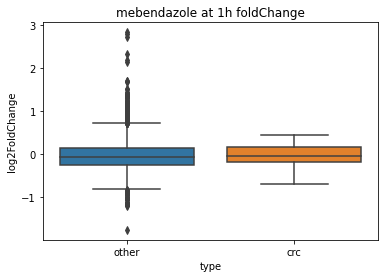

In [209]:
ax = sns.boxplot(data=res,x='type',y='log2FoldChange')
ax.set_title("{} at {} foldChange".format(project.split("_")[0], cond))

ax.figure.savefig("{}/plots/{}_whiskers_{}_logfc.pdf".format(res_dir, project, "_".join(
    filter(None, [scaling, str(minvar_toremove), str(mincount_toremove)]))))

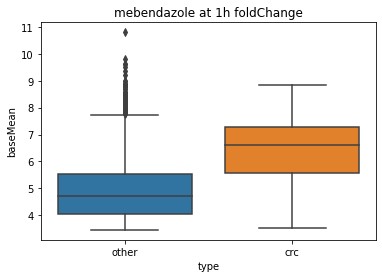

In [210]:
ax =sns.boxplot(data=res,x='type',y='baseMean')
ax.set_title("{} at {} foldChange".format(project.split("_")[0], cond))

ax.figure.savefig("{}/plots/{}_whiskers_{}_beaseMean.pdf".format(res_dir, project, "_".join(
    filter(None, [scaling, str(minvar_toremove), str(mincount_toremove)]))))

## volcano plots

In [213]:
res.head()

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,genes,gene_id,type
1,3.731864,-0.348474,0.377780,0.922427,0.356306,NaN,NAT1,NAT1,other
3,3.828351,-0.146420,0.376884,0.388502,0.697645,NaN,AARS1,AARS1,other
8,4.351859,-0.608343,0.296640,2.050779,0.040288,NaN,ABCF1,ABCF1,other
9,4.404957,0.295079,0.318618,-0.926121,0.354383,0.733317,ABL1,ABL1,other
10,4.792115,-0.375734,0.253917,1.479753,0.138939,0.526033,ABL2,ABL2,other


In [232]:
volcano_folder = "{}/plots/{}_{}".format(res_dir, project, "_".join(
    filter(None, [scaling, str(minvar_toremove), str(mincount_toremove)])))
print(volcano_folder)

../results/slamseq_mebendazole_v1//plots/mebendazole_v1_0_5


In [233]:
genepyPlot.volcano(res, tohighlight=crcs, title="MV411 Mebendazole",
                   searchbox=True, folder=volcano_folder)

AttributeError: unexpected attribute 'output_backend' to Column, possible attributes are align, aspect_ratio, background, children, css_classes, disabled, height, height_policy, js_event_callbacks, js_property_callbacks, margin, max_height, max_width, min_height, min_width, name, rows, sizing_mode, spacing, subscribed_events, syncable, tags, visible, width or width_policy

In [231]:
p = genepyPlot.volcano(res, tohighlight=crcs, title="MV411 Mebendazole")
                   #showlabels=True, folder=volcano_folder)

# Looking at slamdunk output for Scarlett

In [7]:
project = project
res_folder = "res"
location = "../../data/slamseq_"+project+"/"+res_folder+"/"+"count/"
print(location)

../../data/slamseq_mebendazole_v1/res/count/


In [8]:
# remove genes that have very low counts
mincount_toremove=5

# remove genes that have a variance of 0 across all samples (these we really want to remove)
# genes that have values of 0,1,2 everywhere
minvar_toremove=0

<li>readcounts: total counts of every transscript (output of slamdunk algorithm
<li>tccounts: t to c converted RNA transcripts

In [9]:
%%time

# all genes (not just protein coding)
readcounts, tccounts = rna.readFromSlamdunk(loc=location, 
                                            minvar_toremove=minvar_toremove, 
                                            mincount_toremove=mincount_toremove,
                                            verbose=False)

found 10 files:dict_keys(['mr522-MV411-DMSO-r1_tcount', 'mr523-MV411-DMSO-r2_tcount', 'mr524-MV411-DMSO-r3_tcount', 'mr525-MV411-DMSO-r4_tcount', 'mr526-MV411-DMSO-r5_tcount', 'mr527-MV411-Mebendazole-r1_tcount', 'mr528-MV411-Mebendazole-r2_tcount', 'mr529-MV411-Mebendazole-r3_tcount', 'mr530-MV411-Mebendazole-r4_tcount', 'mr531-MV411-Mebendazole-r5_tcount'])
mr522-MV411-DMSO-r1
mr523-MV411-DMSO-r2
mr524-MV411-DMSO-r3
mr525-MV411-DMSO-r4
mr526-MV411-DMSO-r5
mr527-MV411-Mebendazole-r1
mr528-MV411-Mebendazole-r2
mr529-MV411-Mebendazole-r3
mr530-MV411-Mebendazole-r4
mr531-MV411-Mebendazole-r5
downloading gene names from biomart
1750 count not be parsed... we don't have all genes already
downloading gene names from biomart
1750 count not be parsed... we don't have all genes already
CPU times: user 1min 25s, sys: 1.12 s, total: 1min 26s
Wall time: 2min 22s


In [10]:
def dedup_df_genes(df):
    ''' sum rows with the same gene index and remove duplicate '''
    if df.shape[0] != len(df.index.drop_duplicates()):
        print("Duplicate gene rows!")
        print("{} rows | {} unique genes".format(df.shape[0], len(df.index.drop_duplicates())))
        print("Summing of duplicate gene rows.")
        
    # sum duplicate rows, same row order
    duplicate_genes = df.index[df.index.duplicated()].tolist()
    df = df.groupby(df.index).sum().loc[df.index.drop_duplicates()]
    if df.shape[0] != len(df.index.drop_duplicates()):
        raise ValueError(
            "Cannot collapse duplicate gene rows."
        )
    
    return df, duplicate_genes

In [11]:
readcounts, duplicate_genes = dedup_df_genes(readcounts)
tccounts, duplicate_genes = dedup_df_genes(tccounts)

if readcounts.shape != tccounts.shape:
    raise ValueError("readcounts and tccounts not the same dimensions: {} | {}".format(readcounts.shape, tccounts.shape))

Duplicate gene rows!
14323 rows | 14292 unique genes
Summing of duplicate gene rows.
Duplicate gene rows!
14323 rows | 14292 unique genes
Summing of duplicate gene rows.


In [24]:
files = ! ls $location/*tsv
[os.path.basename(f) for f in files]

['mr522-MV411-DMSO-r1_tcount.tsv',
 'mr523-MV411-DMSO-r2_tcount.tsv',
 'mr524-MV411-DMSO-r3_tcount.tsv',
 'mr525-MV411-DMSO-r4_tcount.tsv',
 'mr526-MV411-DMSO-r5_tcount.tsv',
 'mr527-MV411-Mebendazole-r1_tcount.tsv',
 'mr528-MV411-Mebendazole-r2_tcount.tsv',
 'mr529-MV411-Mebendazole-r3_tcount.tsv',
 'mr530-MV411-Mebendazole-r4_tcount.tsv',
 'mr531-MV411-Mebendazole-r5_tcount.tsv']

In [25]:
df_counts = [pd.read_csv(f, header=[0], index_col=None, sep="\t", squeeze=True, low_memory=True, comment="#") for f in files]


In [28]:
[df.shape for df in df_counts]

[(58136, 16),
 (58136, 16),
 (58136, 16),
 (58136, 16),
 (58136, 16),
 (58136, 16),
 (58136, 16),
 (58136, 16),
 (58136, 16),
 (58136, 16)]

In [27]:
df = df_counts[0]
df.head()

,Chromosome,Start,End,Name,Length,Strand,ConversionRate,ReadsCPM,Tcontent,CoverageOnTs,ConversionsOnTs,ReadCount,TcReadCount,multimapCount,ConversionRateLower,ConversionRateUpper
0,chr22,29442122,29442455,5988,333,+,0.000000,0.000000,112,0,0,0,0,0,-1.0,-1.0
1,chr19,13961529,13962694,5989,1165,-,0.000000,0.456889,242,408,0,14,0,0,-1.0,-1.0
2,chr12,109448654,109451813,83892,3159,-,0.002439,12.401262,921,15173,37,380,14,1,-1.0,-1.0
3,chr12,109456117,109456313,83892,196,-,0.002857,0.652698,57,700,2,20,1,0,-1.0,-1.0
4,chr12,109457629,109457682,83892,53,-,0.000000,0.097905,10,30,0,3,0,0,-1.0,-1.0


In [57]:
df_stats = pd.DataFrame({"treatment":["DMSO"]*5+["mebendazole"]*5,
                         "mean":[d["ConversionRate"].mean() for d in df_counts],
                         "median":[df["ConversionRate"].median() for d in df_counts]})

In [64]:
df_stats

,treatment,mean,median
0,DMSO,0.002350,0.0
1,DMSO,0.002183,0.0
2,DMSO,0.002163,0.0
3,DMSO,0.003025,0.0
4,DMSO,0.002372,0.0
5,mebendazole,0.002114,0.0
6,mebendazole,0.002334,0.0
7,mebendazole,0.002120,0.0
8,mebendazole,0.002447,0.0
9,mebendazole,0.001875,0.0


In [54]:
project2 = "inhibitors_v1"
files2 = ! ls ../../data/slamseq_$project2/res/count/*tsv
print(len(files2))
[os.path.basename(f) for f in files2]

30


['mr492-MV411-DMSO-r1_tcount.tsv',
 'mr493-MV411-DMSO-r2_tcount.tsv',
 'mr494-MV411-DMSO-r3_tcount.tsv',
 'mr495-MV411-DMSO-r4_tcount.tsv',
 'mr496-MV411-DMSO-r5_tcount.tsv',
 'mr497-MV411-Naphthol-r1_tcount.tsv',
 'mr498-MV411-Naphthol-r2_tcount.tsv',
 'mr499-MV411-Naphthol-r3_tcount.tsv',
 'mr500-MV411-Naphthol-r4_tcount.tsv',
 'mr501-MV411-Naphthol-r5_tcount.tsv',
 'mr502-MV411-Plumbagin-r1_tcount.tsv',
 'mr503-MV411-Plumbagin-r2_tcount.tsv',
 'mr504-MV411-Plumbagin-r3_tcount.tsv',
 'mr505-MV411-Plumbagin-r4_tcount.tsv',
 'mr506-MV411-Plumbagin-r5_tcount.tsv',
 'mr507-MV411-Celastrol-r1_tcount.tsv',
 'mr508-MV411-Celastrol-r2_tcount.tsv',
 'mr509-MV411-Celastrol-r3_tcount.tsv',
 'mr510-MV411-Celastrol-r4_tcount.tsv',
 'mr511-MV411-Celastrol-r5_tcount.tsv',
 'mr512-MV411-TM1-001-r1_tcount.tsv',
 'mr513-MV411-TM1-001-r2_tcount.tsv',
 'mr514-MV411-TM1-001-r3_tcount.tsv',
 'mr515-MV411-TM1-001-r4_tcount.tsv',
 'mr516-MV411-TM1-001-r5_tcount.tsv',
 'mr517-MV411-Tretinoin-r1_tcount.tsv',


In [55]:
df_counts2 = [pd.read_csv(f, header=[0], index_col=None, sep="\t", squeeze=True, low_memory=True, comment="#")
              for f in files2]
len(df_counts2)

30

In [58]:
df_stats2 = pd.DataFrame({"treatment":np.repeat(["DMSO","Naphthol","Plumbagin","Celastrol","TM1-001","Tretinoin"],5).tolist(),
                          "mean":[d["ConversionRate"].mean() for d in df_counts2], "median":[df["ConversionRate"].median() for d in df_counts2]})

In [59]:
df_stats.describe()

,mean,median
count,10.000000,10.0
mean,0.002298,0.0
std,0.000305,0.0
min,0.001875,0.0
25%,0.002131,0.0
50%,0.002259,0.0
75%,0.002367,0.0
max,0.003025,0.0


In [65]:
df_stats2

,treatment,mean,median
0,DMSO,0.001894,0.0
1,DMSO,0.002714,0.0
2,DMSO,0.001970,0.0
3,DMSO,0.002610,0.0
4,DMSO,0.002166,0.0
5,Naphthol,0.003097,0.0
6,Naphthol,0.003164,0.0
7,Naphthol,0.003333,0.0
8,Naphthol,0.002872,0.0
9,Naphthol,0.003662,0.0


In [60]:
df_stats2.describe()

,mean,median
count,30.000000,30.0
mean,0.003011,0.0
std,0.000722,0.0
min,0.001894,0.0
25%,0.002585,0.0
50%,0.003078,0.0
75%,0.003317,0.0
max,0.004747,0.0


In [61]:
project3 = "MYB_degraded_timecourse_v1"
files3 = ! ls ../../data/slamseq_$project3/res/count/*tsv
print(len(files3))
[os.path.basename(f) for f in files3]

70


['mr422-MV411-MYB-dTAG-DMSO_1h-r1_tcount.tsv',
 'mr423-MV411-MYB-dTAG-DMSO_1h-r2_tcount.tsv',
 'mr424-MV411-MYB-dTAG-DMSO_1h-r3_tcount.tsv',
 'mr425-MV411-MYB-dTAG-DMSO_1h-r4_tcount.tsv',
 'mr426-MV411-MYB-dTAG-DMSO_1h-r5_tcount.tsv',
 'mr427-MV411-MYB-dTAG-VHL_1h-r1_tcount.tsv',
 'mr428-MV411-MYB-dTAG-VHL_1h-r2_tcount.tsv',
 'mr429-MV411-MYB-dTAG-VHL_1h-r3_tcount.tsv',
 'mr430-MV411-MYB-dTAG-VHL_1h-r4_tcount.tsv',
 'mr431-MV411-MYB-dTAG-VHL_1h-r5_tcount.tsv',
 'mr432-MV411-MYB-dTAG-DMSO_2h-r1_tcount.tsv',
 'mr433-MV411-MYB-dTAG-DMSO_2h-r2_tcount.tsv',
 'mr434-MV411-MYB-dTAG-DMSO_2h-r3_tcount.tsv',
 'mr435-MV411-MYB-dTAG-DMSO_2h-r4_tcount.tsv',
 'mr436-MV411-MYB-dTAG-DMSO_2h-r5_tcount.tsv',
 'mr437-MV411-MYB-dTAG-VHL_2h-r1_tcount.tsv',
 'mr438-MV411-MYB-dTAG-VHL_2h-r2_tcount.tsv',
 'mr439-MV411-MYB-dTAG-VHL_2h-r3_tcount.tsv',
 'mr440-MV411-MYB-dTAG-VHL_2h-r4_tcount.tsv',
 'mr441-MV411-MYB-dTAG-VHL_2h-r5_tcount.tsv',
 'mr442-MV411-MYB-dTAG-DMSO_4h-r1_tcount.tsv',
 'mr443-MV411-MYB-dTAG-

In [62]:
df_counts3 = [pd.read_csv(f, header=[0], index_col=None, sep="\t", squeeze=True, low_memory=True, comment="#")
              for f in files3]
len(df_counts3)

70

In [63]:
df_counts3[0]

,Chromosome,Start,End,Name,Length,Strand,ConversionRate,ReadsCPM,Tcontent,CoverageOnTs,ConversionsOnTs,ReadCount,TcReadCount,multimapCount,ConversionRateLower,ConversionRateUpper
0,chr22,29442122,29442455,5988,333,+,0.000000,0.000000,112,0,0,0,0,0,-1.0,-1.0
1,chr19,13961529,13962694,5989,1165,-,0.007117,0.459344,242,1686,12,63,6,0,-1.0,-1.0
2,chr12,109448654,109451813,83892,3159,-,0.002288,11.636715,921,60322,138,1596,41,5,-1.0,-1.0
3,chr12,109456117,109456313,83892,196,-,0.000000,0.196862,57,1030,0,27,0,0,-1.0,-1.0
4,chr12,109457629,109457682,83892,53,-,0.000000,0.021874,10,30,0,3,0,0,-1.0,-1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58131,chr1,46691873,46692098,100130197,225,+,0.000000,0.153115,61,394,0,21,0,0,-1.0,-1.0
58132,chr2,101151659,101152759,100506286,1100,+,0.000000,0.036456,191,62,0,5,0,0,-1.0,-1.0
58133,chr2,101154034,101155412,100506286,1378,+,0.002967,0.182279,337,674,2,25,1,0,-1.0,-1.0
58134,chrX,106639813,106639896,100616144,83,+,0.000000,0.000000,25,0,0,0,0,0,-1.0,-1.0
